# GETTING STARTED
This is interactive code, which runs sequentially in cells. 
You can run each cell independently or run everything all at once.

You cannot run a cell without running the cells above it or it will have errors.

To run everything at once:
- Go to the 'Run' menu at the top. Sometimes this menu is called 'Cells'
- Tap 'Run All Cells'/'Run All'.
- Click the links below to see the fancy plots. They are interactive.


### Links

*These links will not work until you 'Run All Cells' as instructed above*

#### Stock info
- [Click here to modify tracked stocks](#stocks)
- [Click here to see the chart with stocks](#plot_china_nonchina_stocks)

#### Other plots
- [Plot Confirmed Cases for China/non-China](#plot_china_nonchina)
- [Plot Confirmed Cases for Top Countries](#plot_top_countries_confirmed)
- [Plot Growth for Top Countries](#plot_top_countries_growth)
- [Plot Acceleration for Top Countries](#plot_top_countries_acceleration)

## Download dataset 

Dataset is at https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/

In [20]:
import pandas as pd
import requests
import io

confirmedUrl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

r = requests.get(confirmedUrl)
if r.ok:
    data = r.content.decode('utf8')
    df = pd.read_csv(io.StringIO(data))
    
# Rename Province/State and Country/Region
df = df.rename(columns={'Province/State': 'provincestate', 'Country/Region': 'countryregion'})

# Remove unneeded columns
df = df.drop(['Lat', 'Long', 'provincestate'], axis=1)

# Reshape 
df_confirmed = df.melt(var_name='date', value_name='confirmed', id_vars='countryregion')
df_confirmed['date'] = pd.to_datetime(df_confirmed['date'])

date_min = df_confirmed['date'].min()
date_max = df_confirmed['date'].max()
print('Retrieved results from {} to {}'.format(date_min, date_max))


Retrieved results from 2020-01-22 00:00:00 to 2020-04-06 00:00:00


In [21]:
### Group values by countryregion
df_confirmed_grouped = df_confirmed[['date','countryregion', 'confirmed']].groupby(['date', 'countryregion']).sum()

## Calculate metrics

In [38]:
# Calculate change
window = 3
growthCalculation = lambda x: (x.max())

from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()

x = pd.Series(range(0,window)).values.reshape(-1,1)
linearCoefficient = lambda values: (linear_regressor.fit(x, values.values.reshape(-1,1)).coef_)

df_confirmed_grouped = df_confirmed_grouped.reset_index()
df_confirmed_grouped['growth_rate'] = df_confirmed_grouped.groupby(['countryregion'])['confirmed'].rolling(window).apply(linearCoefficient).fillna(0).reset_index(level=0, drop=True)
df_confirmed_grouped['acceleration'] = df_confirmed_grouped['growth_rate'].rolling(window).apply(linearCoefficient).fillna(0)

df_confirmed_grouped.head(10)

,index,date,countryregion,confirmed,growth_rate,acceleration
0,0,2020-01-22,Afghanistan,0,0.0,0.0
1,1,2020-01-22,Albania,0,0.0,0.0
2,2,2020-01-22,Algeria,0,0.0,0.0
3,3,2020-01-22,Andorra,0,0.0,0.0
4,4,2020-01-22,Angola,0,0.0,0.0
5,5,2020-01-22,Antigua and Barbuda,0,0.0,0.0
6,6,2020-01-22,Argentina,0,0.0,0.0
7,7,2020-01-22,Armenia,0,0.0,0.0
8,8,2020-01-22,Australia,0,0.0,0.0
9,9,2020-01-22,Austria,0,0.0,0.0


## Prepare China data for plotting

In [39]:
# Prepare China
df_china = df_confirmed_grouped.query('countryregion == "China"').copy()
df_china_prepared = df_china.groupby('date').sum()

df_china_prepared.head()

,index,confirmed,growth_rate,acceleration
date,,,,
2020-01-22,36,548,0.0,0.00
2020-01-23,220,643,0.0,0.00
2020-01-24,404,920,186.0,93.00
2020-01-25,588,1406,381.5,190.75
2020-01-26,772,2075,577.5,288.75


In [40]:
# Convert to tidy format
df_china_prepared = df_china_prepared.reset_index()

df_china_prepared.head()

,date,index,confirmed,growth_rate,acceleration
0,2020-01-22,36,548,0.0,0.00
1,2020-01-23,220,643,0.0,0.00
2,2020-01-24,404,920,186.0,93.00
3,2020-01-25,588,1406,381.5,190.75
4,2020-01-26,772,2075,577.5,288.75


## Prepare non-China data for plotting

In [41]:
# Prepare non-China
# print(df_confirmed_grouped.index.unique(level='countryregion'))
df_non_china = df_confirmed_grouped.query('countryregion != ""').copy()

# Drop growth rate calculations as they were done per country
df_non_china = df_non_china.drop(['growth_rate', 'acceleration'], axis=1)
df_non_china = df_non_china.groupby('date').sum()

df_non_china.head(10)

,index,confirmed
date,,
2020-01-22,16836,555
2020-01-23,50692,654
2020-01-24,84548,941
2020-01-25,118404,1434
2020-01-26,152260,2118
2020-01-27,186116,2927
2020-01-28,219972,5578
2020-01-29,253828,6166
2020-01-30,287684,8234


In [42]:
# Calculate growth again
df_non_china['growth_rate'] = df_non_china['confirmed'].rolling(window).apply(linearCoefficient).fillna(0)
df_non_china['acceleration'] = df_non_china['growth_rate'].rolling(window).apply(linearCoefficient).fillna(0)

print(df_non_china.shape)
df_non_china.head()

(76, 4)


,index,confirmed,growth_rate,acceleration
date,,,,
2020-01-22,16836,555,0.0,0.00
2020-01-23,50692,654,0.0,0.00
2020-01-24,84548,941,193.0,96.50
2020-01-25,118404,1434,390.0,195.00
2020-01-26,152260,2118,588.5,197.75


In [43]:
# Convert to 'tidy' format for plotting
df_non_china_prepared = df_non_china.reset_index()
df_non_china_prepared.head()

,date,index,confirmed,growth_rate,acceleration
0,2020-01-22,16836,555,0.0,0.00
1,2020-01-23,50692,654,0.0,0.00
2,2020-01-24,84548,941,193.0,96.50
3,2020-01-25,118404,1434,390.0,195.00
4,2020-01-26,152260,2118,588.5,197.75


<a id='stocks'></a>
# Get stock data

In [44]:
# MODIFY THESE TO ADD YOUR STOCKS
stocks_covid_pharma = ['MRNA', 'REGN', 'INO'] # From http://www.marketwatch.com/story/think-twice-before-investing-in-biotech-companies-working-on-coronavirus-treatments-the-odds-of-picking-a-winner-are-low-2020-03-18
stocks_indices = ['SPY', 'AC', 'DJI']
stocks_indices2 = ['S5COND', 'S5CONS', 'S5HLTH', 'SPCFD', 'S5INFT', 'S5MATR', 'S5REAS', 'S5TELS', 'S5UTIL', 'SPF', 'SPN'] # From https://www.tradingview.com/markets/indices/quotes-snp/
stocks_indices3 = ['BFX'] # From https://ca.finance.yahoo.com/world-indices/
stocks_indices4 = ['VTI', 'SCHF', 'IEMG', 'VIG', 'VTEB', 'TIMXX'] # From Wealthfront

# Combine everything
stocks_to_track = stocks_indices + stocks_covid_pharma + stocks_indices3 + stocks_indices4

In [45]:
import yfinance as yf

def getStockInfo(tickerSymbol, date_min, date_max):
    msft = yf.Ticker(tickerSymbol)
    stocks = msft.history(start=date_min, end=date_max)
    stocks['Ticker'] = tickerSymbol
    stocks['Close % Change'] = stocks['Close'].pct_change().fillna(0)
    return stocks[['Close % Change', 'Ticker']]

from functools import reduce

stocks = pd.concat(map(lambda x: getStockInfo(x, date_min, date_max), stocks_to_track)).reset_index()

stocks.head(200)

- BFX: No data found for this date range, symbol may be delisted
- TIMXX: No data found for this date range, symbol may be delisted


,Date,Close % Change,Ticker
0,2020-01-22,0.000000,SPY
1,2020-01-23,0.001154,SPY
2,2020-01-24,-0.008885,SPY
3,2020-01-27,-0.016032,SPY
4,2020-01-28,0.010479,SPY
...,...,...,...
195,2020-03-24,-0.028227,MRNA
196,2020-03-25,0.050736,MRNA
197,2020-03-26,0.029856,MRNA
198,2020-03-27,0.075519,MRNA


## Plot
### Prepare chart

In [46]:
# Show fig
import plotly.express as px
import plotly.graph_objects as go

colorSequence = ["red", "royalblue"]

layout = go.Layout(title="COVID-19 in China and non-China", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Stock price % change'},                   
                   yaxis2={'title': 'Growth rate/accel in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False, 'position': 1},
                   yaxis3={'title': 'Confirmed cases', 
                           "showgrid": False,
                           'overlaying': 'y',
                           'side': 'right',
                           'position': 0.92},
                   xaxis={"title": "Date",
                         'domain': [0, 0.92]},
                   height=1000)

chinaColor = colorSequence[0]
nonChinaColor = colorSequence[1]

# Only plot 'confirmed', since we can't control the dashed lines and second-axes using Plotly Express
trace_confirmed_china = go.Scatter(x=df_china_prepared['date'], 
                                y=df_china_prepared['confirmed'], 
                                name='Confirmed (China)',
                                line=dict(color=chinaColor, 
                                          width=4), 
                                yaxis="y3")

trace_confirmed_non_china = go.Scatter(x=df_non_china_prepared['date'], 
                                y=df_non_china_prepared['confirmed'], 
                                name='Confirmed (non-China)',
                                line=dict(color=nonChinaColor, 
                                          width=4), 
                                yaxis="y3")

# Reset index
df_non_china_flattened = df_non_china.reset_index()

# Add growth rate
trace_growth_china = go.Scatter(x=df_china['date'], 
                                y=df_china['growth_rate'], 
                                name='Growth rate (China)',
                                line=dict(color=chinaColor, 
                                          width=4, 
                                          dash='dash'), 
                                yaxis="y2")
trace_growth_non_china = go.Scatter(x=df_non_china_flattened['date'], 
                                    y=df_non_china_flattened['growth_rate'], 
                                    name='Growth rate (non-China)',
                                    line=dict(color=nonChinaColor, 
                                              width=4, 
                                              dash='dash'), 
                                    yaxis="y2")

# Add acceleration
trace_accel_china = go.Scatter(x=df_china['date'], 
                               y=df_china['acceleration'], 
                               name='Accel. (China)',
                         line=dict(color=chinaColor, 
                                   width=2, 
                                   dash='dot'), 
                               yaxis="y2")

trace_accel_non_china = go.Scatter(x=df_non_china_flattened['date'], 
                                   y=df_non_china_flattened['acceleration'], 
                                   name='Accel. (non-China)',
                         line=dict(color=nonChinaColor, 
                                   width=2, 
                                   dash='dot'), 
                                   yaxis="y2")

traces_stocks = px.line(stocks, 
                           x='Date', 
                           y='Close % Change', 
                           color='Ticker',).data

<a id='plot_china_nonchina'></a>
### Plot Confirmed Cases for China/non-China

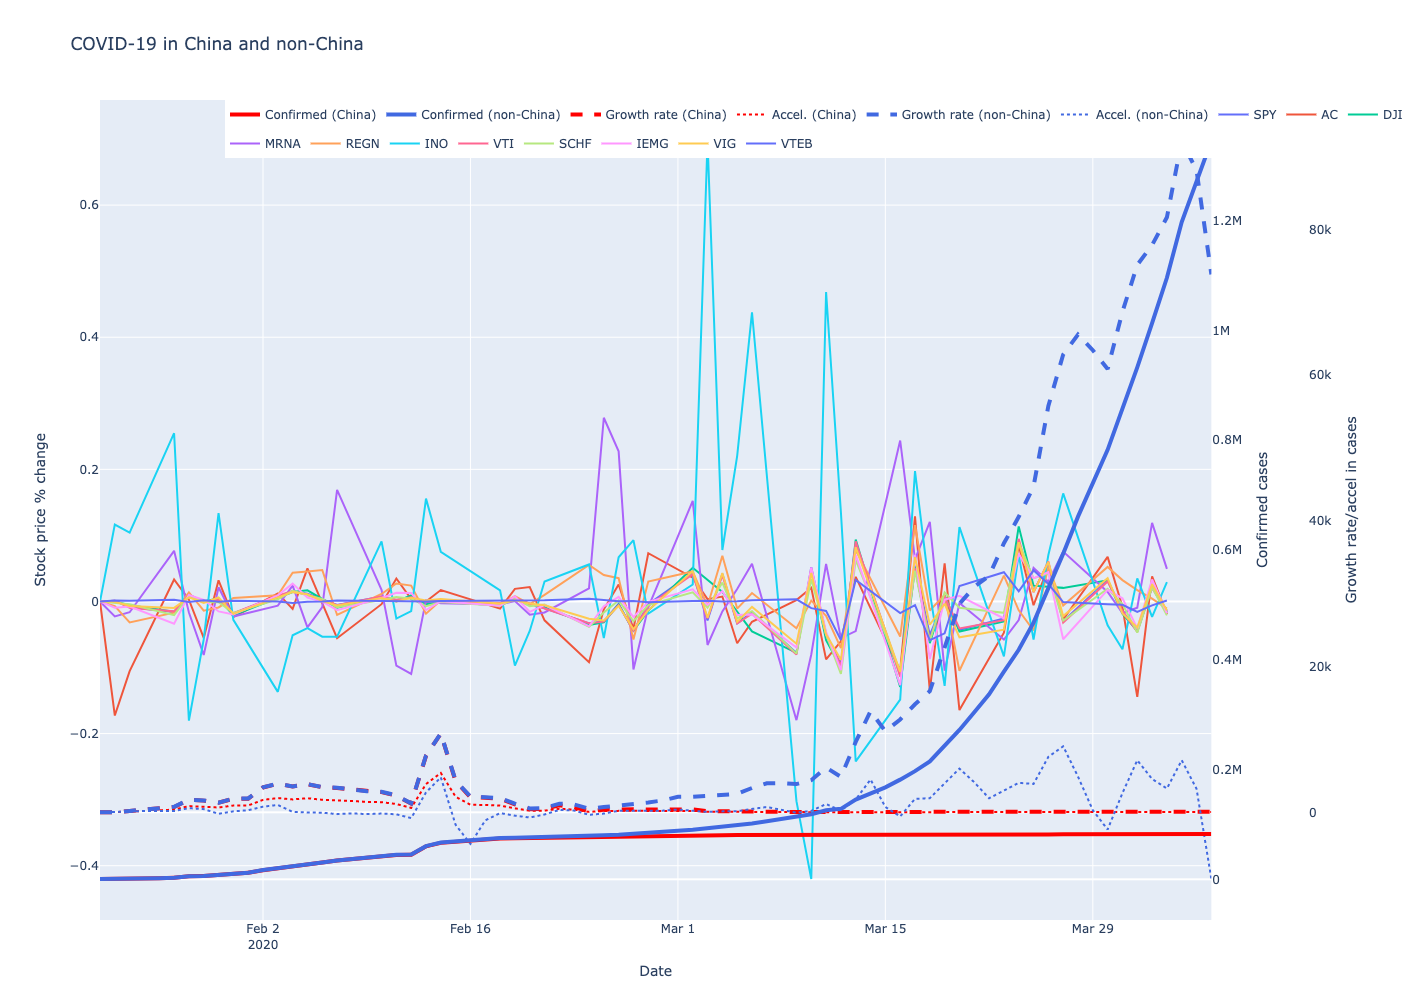

In [47]:
# Combine to make a tuple
traces_combined = (trace_confirmed_china, trace_confirmed_non_china, trace_growth_china, trace_accel_china, trace_growth_non_china, trace_accel_non_china,) + traces_stocks
fig = go.Figure(data=traces_combined, layout=layout)
fig.show()

<a id='plot_china_nonchina_stocks'></a>
### Plot Stocks Against Confirmed Cases for China/non-China

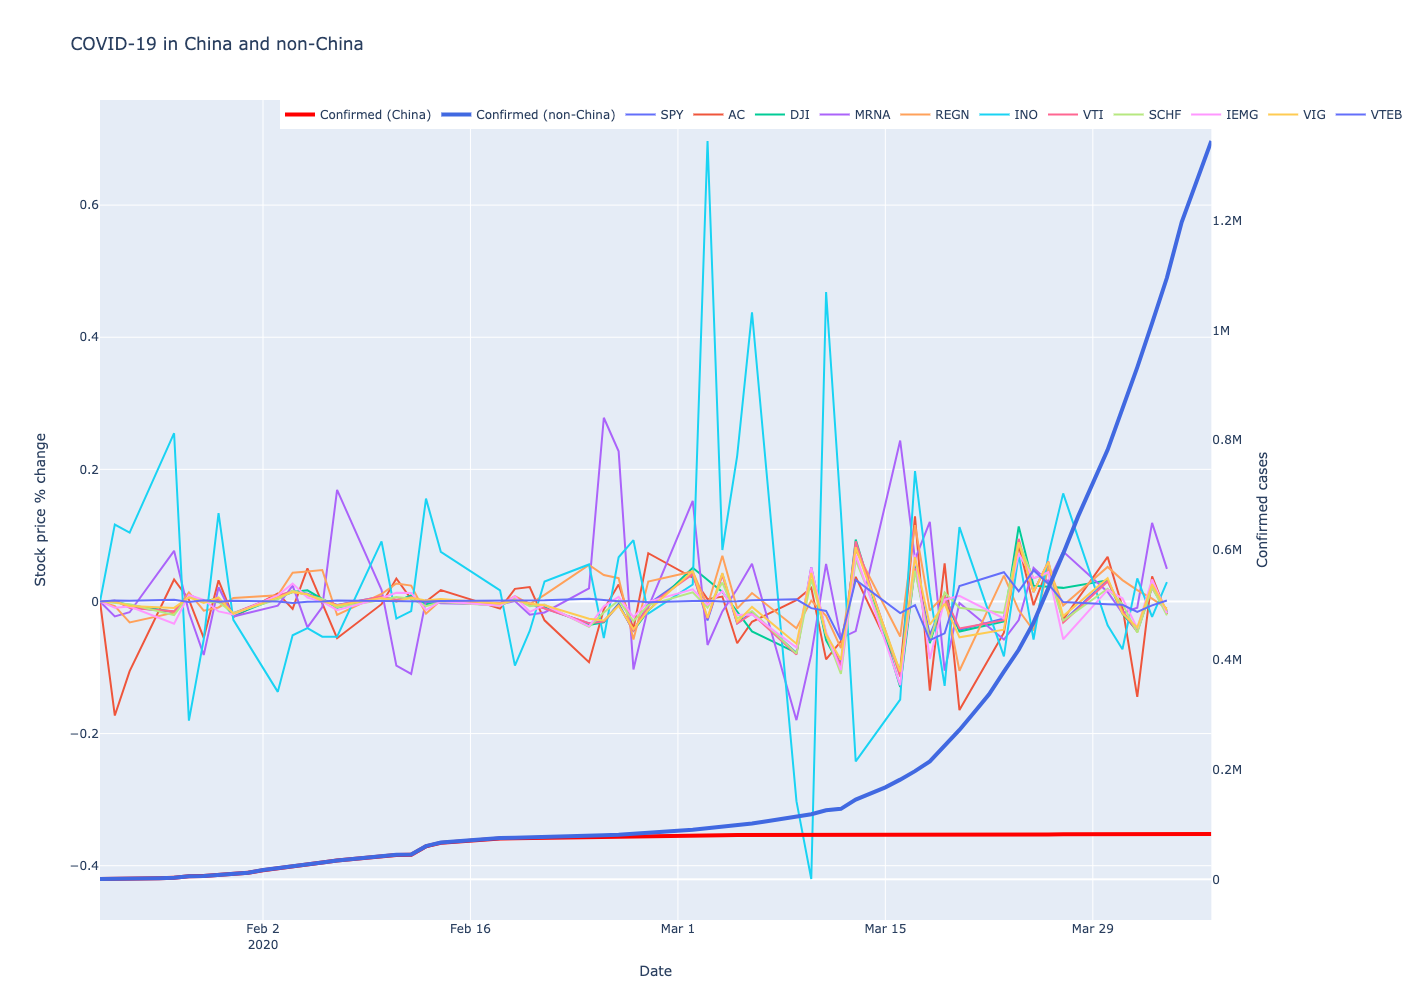

In [48]:
# Combine to make a tuple
traces_combined = (trace_confirmed_china, trace_confirmed_non_china) + traces_stocks
fig = go.Figure(data=traces_combined, layout=layout)
fig.show()

## Prepare top countries for plotting

In [49]:
#Get top ten countries by total cases
df_non_china = df_confirmed_grouped.query('countryregion != "China"').copy()

top_countries_by_total_cases = df_non_china.groupby('countryregion').sum().nlargest(10, 'confirmed').reset_index()['countryregion']
df_non_china_top = df_confirmed_grouped[df_confirmed_grouped.reset_index()['countryregion'].isin(top_countries_by_total_cases)]

df_non_china_top.head()

,index,date,countryregion,confirmed,growth_rate,acceleration
61,61,2020-01-22,France,0,0.0,0.0
65,65,2020-01-22,Germany,0,0.0,0.0
80,80,2020-01-22,Iran,0,0.0,0.0
84,84,2020-01-22,Italy,0,0.0,0.0
90,90,2020-01-22,"Korea, South",1,0.0,0.0


In [50]:
# Only plot 'confirmed', since we can't control the dashed lines and second-axes using Plotly Express
traces_confirmed = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='confirmed', 
                           color='countryregion').data

# Only plot 'growth'
traces_growth = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='growth_rate', 
                           color='countryregion').data

# Only plot 'acceleration'
traces_acceleration = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='acceleration', 
                           color='countryregion').data

# traces_combined = traces_confirmed + traces_growth + traces_acceleration

<a id='plot_top_countries_confirmed'></a>
### Plot Confirmed Cases for Top Countries

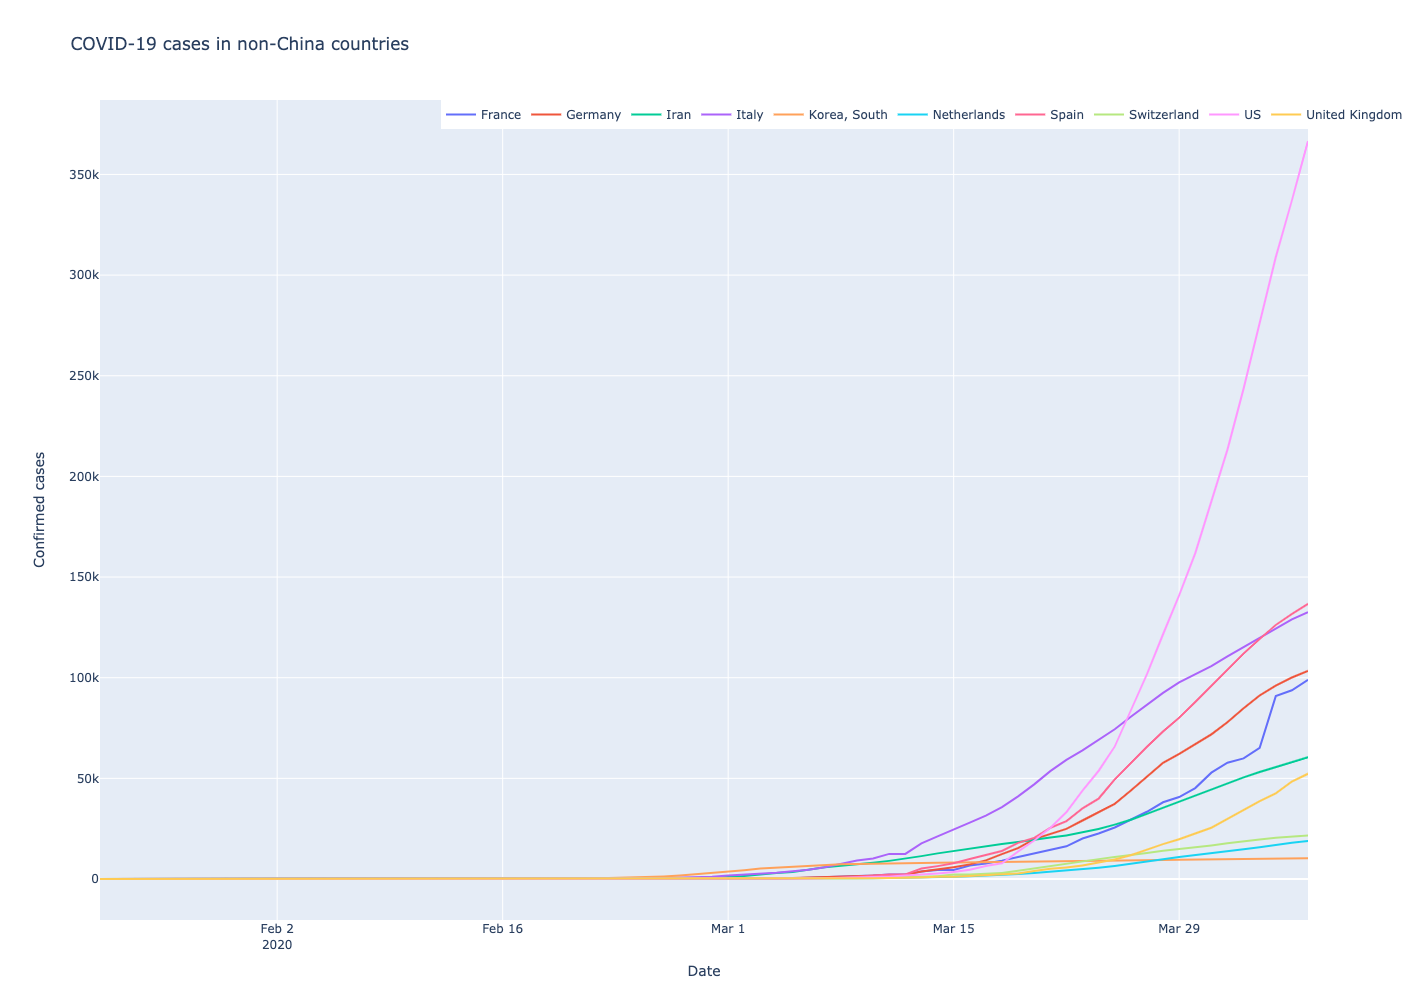

In [51]:
layout = go.Layout(title="COVID-19 cases in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth rate/Accel in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_confirmed, layout=layout)
fig.show()

<a id='plot_top_countries_growth'></a>
### Plot Growth for Top Countries

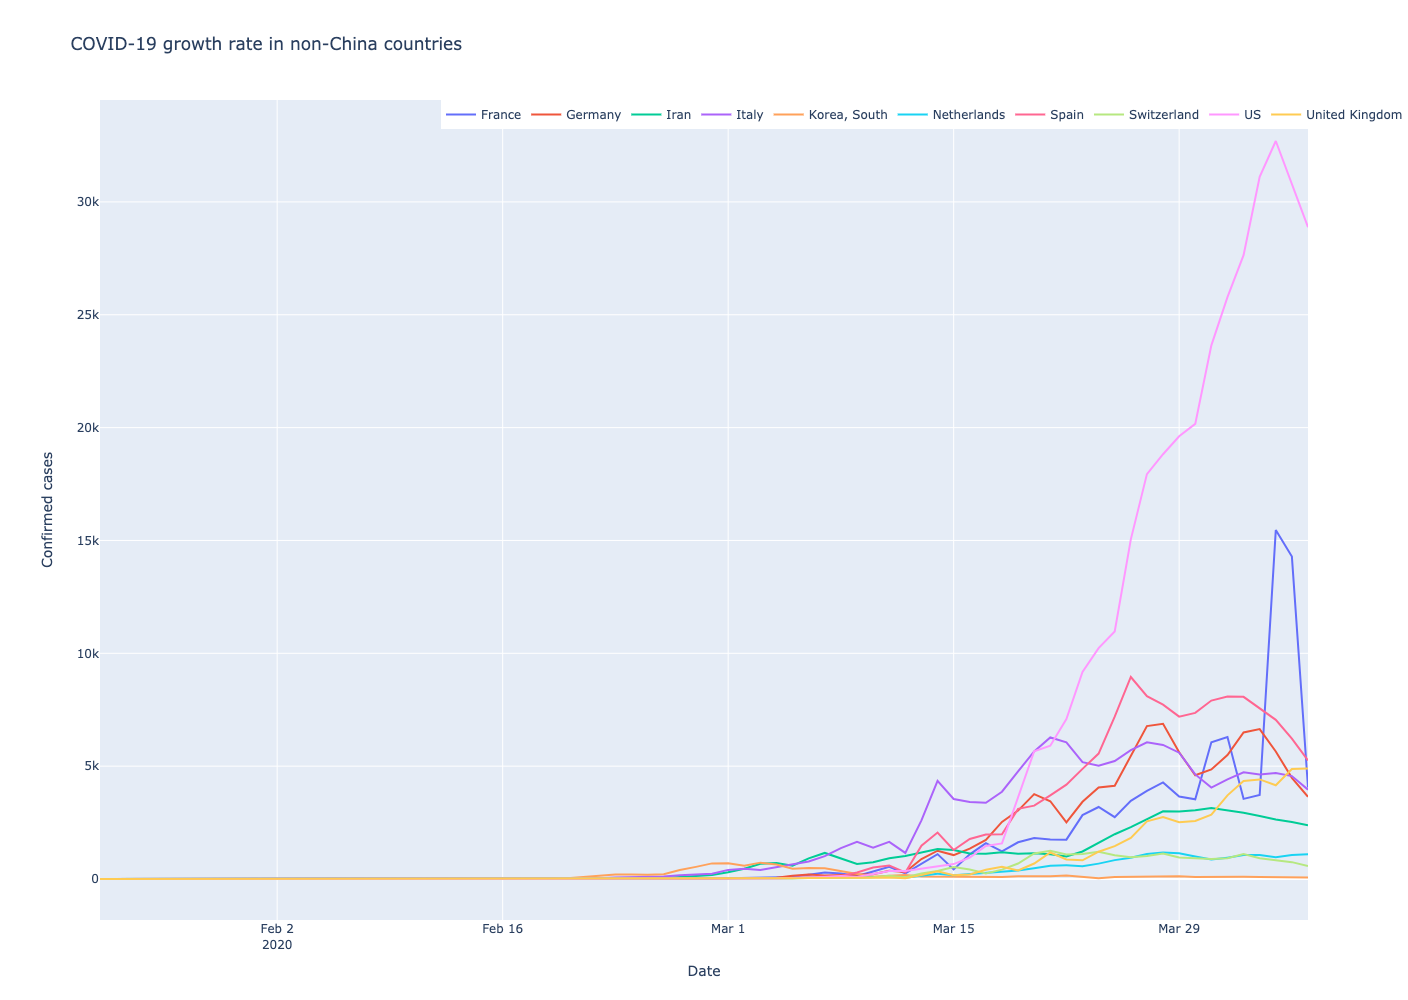

In [52]:
layout = go.Layout(title="COVID-19 growth rate in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_growth, layout=layout)
fig.show()

<a id='plot_top_countries_acceleration'></a>
### Plot Acceleration for Top Countries

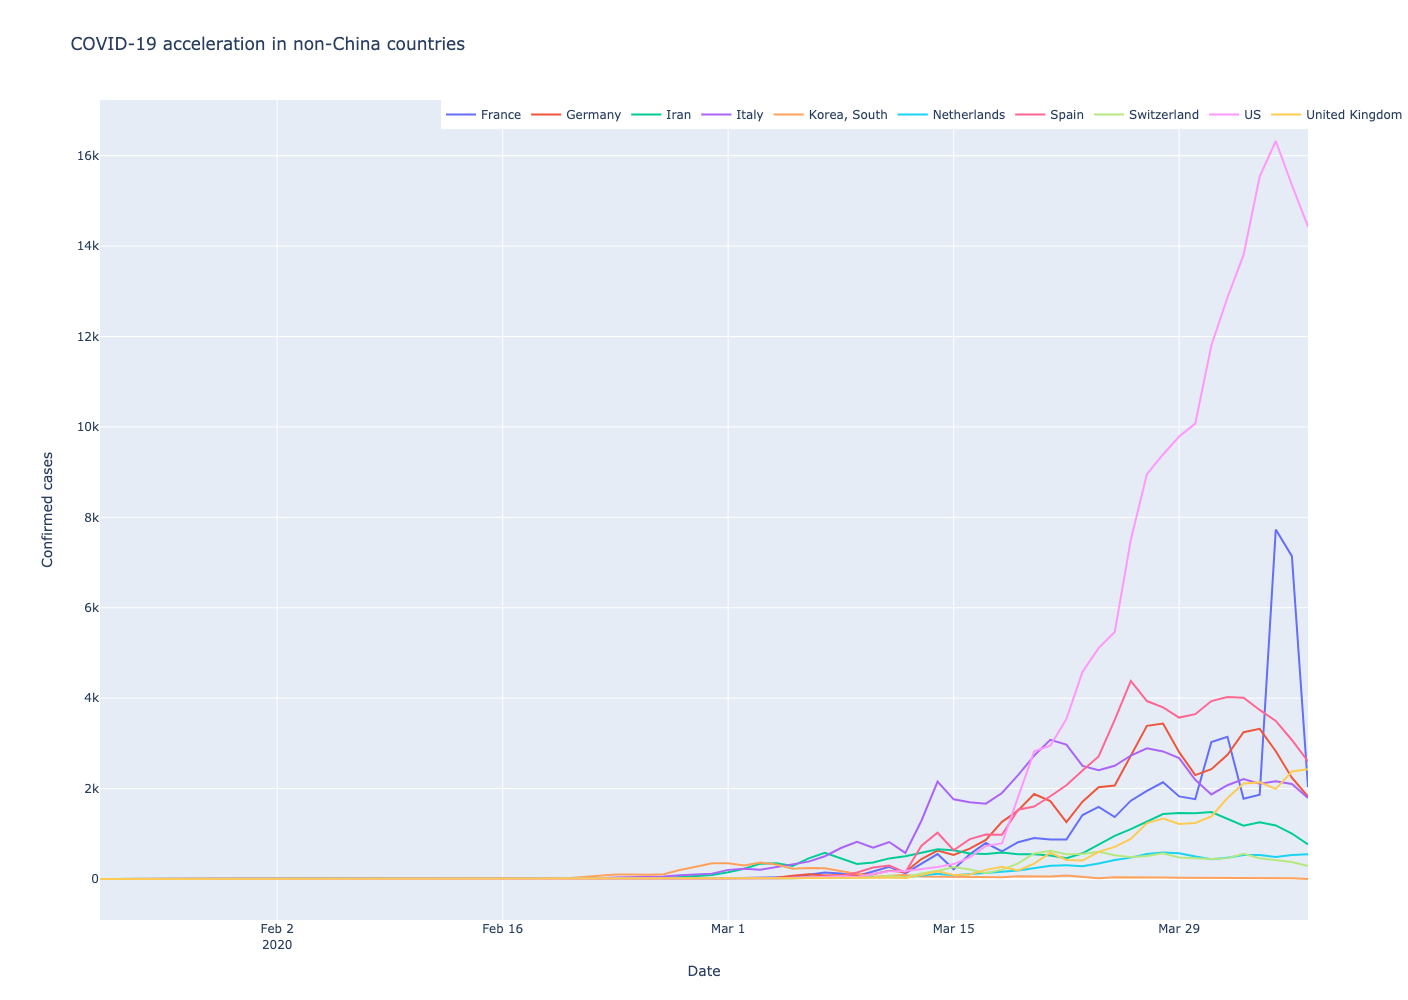

In [53]:
layout = go.Layout(title="COVID-19 acceleration in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Acceleration in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_acceleration, layout=layout)
fig.show()